In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [31]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/TARP project/dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [32]:
data_dir = pathlib.Path("/content/dataset")

In [33]:
yes = list(data_dir.glob('yes/*'))
PIL.Image.open(str(yes[1]))
print(len(yes))

1500


In [34]:
no = list(data_dir.glob('no/*'))
PIL.Image.open(str(no[1]))
print(len(no))

1500


In [35]:
data_dir="/content/dataset"
batch_size = 32
img_height = 180
img_width = 180

In [36]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


In [37]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [38]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


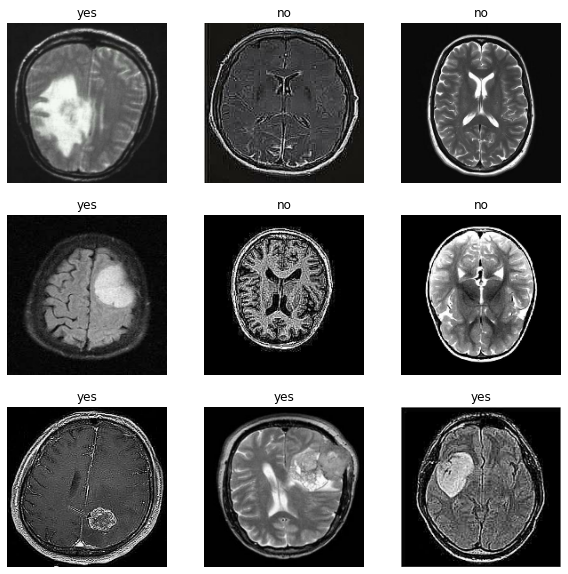

In [39]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [40]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
  #The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

(32, 180, 180, 3)
(32,)


In [41]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [42]:
num_classes = len(class_names)

model1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [43]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [45]:
epochs=10
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
75/75 [==============================] - 79s 1s/step - loss: 0.4027 - accuracy: 0.8200 - val_loss: 0.2126 - val_accuracy: 0.9200
Epoch 2/10
75/75 [==============================] - 67s 879ms/step - loss: 0.1775 - accuracy: 0.9317 - val_loss: 0.1558 - val_accuracy: 0.9483
Epoch 3/10
75/75 [==============================] - 66s 886ms/step - loss: 0.0674 - accuracy: 0.9775 - val_loss: 0.0999 - val_accuracy: 0.9717
Epoch 4/10
75/75 [==============================] - 67s 900ms/step - loss: 0.0344 - accuracy: 0.9896 - val_loss: 0.1309 - val_accuracy: 0.9550
Epoch 5/10
75/75 [==============================] - 65s 867ms/step - loss: 0.0153 - accuracy: 0.9983 - val_loss: 0.1048 - val_accuracy: 0.9750
Epoch 6/10
75/75 [==============================] - 65s 864ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.1096 - val_accuracy: 0.9733
Epoch 7/10
75/75 [==============================] - 66s 885ms/step - loss: 7.0335e-04 - accuracy: 1.0000 - val_loss: 0.1155 - val_accuracy: 0.978

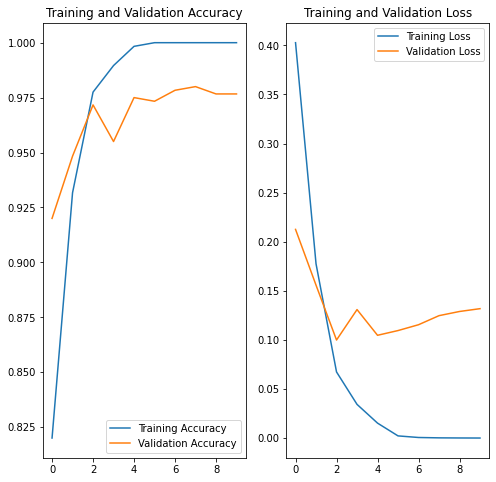

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

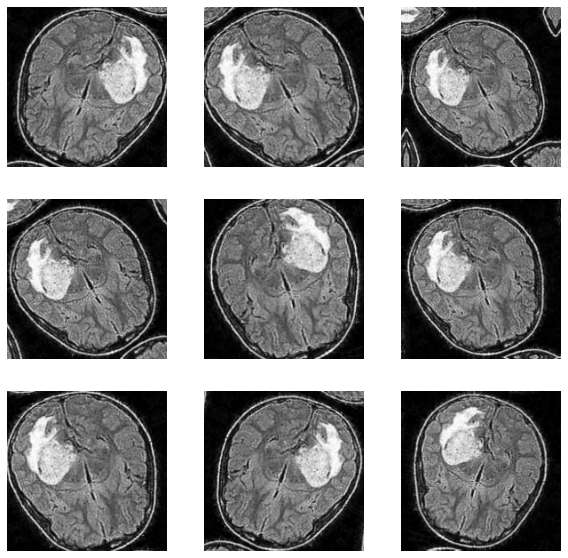

In [48]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [49]:
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [50]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
epochs = 10
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
75/75 [==============================] - 76s 1s/step - loss: 0.6348 - accuracy: 0.6908 - val_loss: 0.4575 - val_accuracy: 0.7933
Epoch 2/10
75/75 [==============================] - 75s 1s/step - loss: 0.4805 - accuracy: 0.7696 - val_loss: 0.3650 - val_accuracy: 0.8417
Epoch 3/10
75/75 [==============================] - 76s 1s/step - loss: 0.4392 - accuracy: 0.8058 - val_loss: 0.3552 - val_accuracy: 0.8517
Epoch 4/10
75/75 [==============================] - 74s 994ms/step - loss: 0.4120 - accuracy: 0.8112 - val_loss: 0.3358 - val_accuracy: 0.8900
Epoch 5/10
75/75 [==============================] - 75s 1s/step - loss: 0.3687 - accuracy: 0.8367 - val_loss: 0.3948 - val_accuracy: 0.8317
Epoch 6/10
75/75 [==============================] - 76s 1s/step - loss: 0.3360 - accuracy: 0.8537 - val_loss: 0.3163 - val_accuracy: 0.8833
Epoch 7/10
75/75 [==============================] - 76s 1s/step - loss: 0.3145 - accuracy: 0.8637 - val_loss: 0.3104 - val_accuracy: 0.8850
Epoch 8/10
75/75 

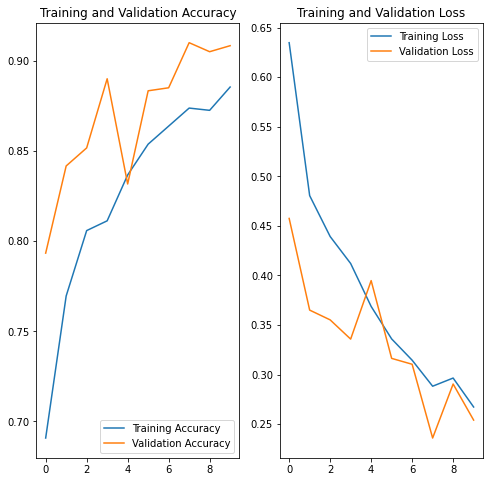

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()